This notebook best viewed here: https://nbviewer.jupyter.org

<a id='home'></a>
This notebook is for the interior variety of Douglas fir GEA mapping pops

#### Purpose
• I've run the baypass commands across four servers, I need to gather the jobs and concatenate results.

#### Notebook outline

1. [rsync files from servers](#rsync)
    - I execute the rsync commands to transfer files from the executing servers to our lab server
1. [ensure complete transfer](#ensure)
    - given the number of gfiles and chains, make sure all of the commands have been executed/transferred

1. [gather all of the wanted resfiles and concat into single dataframes](#combine)
    - gather the files with BF, label SNP IDs, label environmental covariables, and concat into single dataframe
    
    
1. [rank loci](#rank)
    - Rank each locus for each chain by descending BF(dB) score
    - Caclulate mean BF(dB) across 5 chains, rank each locus based on mean
    - Create boolean column with True if locus is ranked in top 1% for at least 3/5 chains
    - Create boolean column with True if locus has BF(dB) >= 15 for at least 3/5 chains
    - Create boolean column with True if locus has BF(dB) >= 20 for at least 3/5 chains
    
1. [look at BF scores for consistent top 1% ranks](#consistent)
    - explore the top 1% of ranks
    - count number of SNPs >= BF(dB) thresholds {15, 20}, print if not all SNPs >= thresh are consistently in top 1% across chains

In [1]:
from pythonimports import *

In [2]:
# dir names
baydir = '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass'
assert op.exists(baydir)
cmddir = op.join(baydir, 'cmd_files')
rundir = op.join(cmddir, 'run_01')
gfile_dir = op.join(baydir, 'individual_gfiles')
shdir = op.join(cmddir, 'shfiles')
resdir = op.join(cmddir, 'results')
rsyncdir = makedir(op.join(baydir, 'rsync_files'))

In [3]:
lview,dview = get_client()

56 56


<a id='rsync'></a>
# rsync files from servers

[top](#home)

In [4]:
fs(rsyncdir)

['/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/rsync_files/beluga_rsync_cmds.txt']

In [5]:
def submit_cmds(cmds):
    """Execute a list of system commands in parallel. Return cmd if there was an error."""
    global jobs
    jobs = []
    for cmd in nb(cmds):
        src,dst = cmd.split()[2:]
        jobs.append(lview.apply_async(rsync, *(src, dst)))
    watch_async(jobs)
    
    badcmds = []
    for i,j in enumerate(jobs):
        try:
            x=j.r
        except:
            badcmds.append(cmds[i])
    print('len(badcmds) = ', len(badcmds))
    
    return badcmds

In [6]:
def check_realfiles(cmds, new=False):
    """Make sure all transferred files exist.
    new is used if transferring the results from SNPs that were once REPEATS
    """
    realfiles = []
#     if new is True:
#         rundir = newrundir
#         gfile_dir = newgfiledir
#         shdir = newshdir
#         resdir = newresdir
    for d in [rundir, gfile_dir, shdir, resdir]:
        realfiles.extend(fs(d, dirs=False))
    
    expfiles = []
    for cmd in cmds:
        expfiles.append(cmd.split()[-1])
    
    print('len(realfiles) = ', len(realfiles))
    print('len(expfiles) =', len(expfiles))
    
    needed = list(set(expfiles) - set(realfiles))
    
    print('needed = ', len(needed))
    
    needed_cmds = []
    for n in needed:
        for cmd in cmds:
            if n in cmd:
                needed_cmds.append(cmd)
    print('needed_cmds = ', len(needed_cmds))
    return needed_cmds

#### cedar cmds

In [7]:
# first from cedar
cmds = read(op.join(rsyncdir, 'beluga_rsync_cmds.txt'))
len(cmds)

41920

In [8]:
cmds[-1].split()

['rsync',
 '-avz',
 'beluga:/scratch/lindb/interior_baypass/cmd_files/shfiles/watcher.sh',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/shfiles/watcher.sh']

In [9]:
dirs = []
for cmd in cmds:
    newfile = cmd.split()[-1]
    dname = op.dirname(newfile)
    dirs.append(dname)
for d in uni(dirs):
    assert op.exists(d)
d

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/shfiles'

In [10]:
cmds[0].split()[2:]

['beluga:/scratch/lindb/interior_baypass/cmd_files/results/interior_all_snps_ADP-lt-1000_gfile_0000_chain_1_DIC.out',
 '/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/results/interior_all_snps_ADP-lt-1000_gfile_0000_chain_1_DIC.out']

In [11]:
badcmds = submit_cmds(cmds)

100%|██████████| 41920/41920 [01:44<00:00, 402.62it/s]



Watching 41920 jobs ...


100%|██████████| 41920/41920 [36:19<00:00, 19.23it/s] 


len(badcmds) =  0


In [12]:
len(badcmds)

0

In [13]:
needed = check_realfiles(cmds)
len(needed)

len(realfiles) =  45491
len(expfiles) = 41920
needed =  0
needed_cmds =  0


0

In [ ]:
badcmds = submit_cmds(needed)

<a id='ensure'></a>
# ensure complete transfer
given the number of gfiles and chains, make sure all of the commands have been executed/transferred

[top](#home)

#### first check to make sure every sh file was exececuted (ie, check that each has a slurm .out file)

In [14]:
# the the shfiles and out files
shfiles = fs(shdir, endswith='.sh', exclude='watcher')
outs = fs(shdir, endswith='.out', exclude='watcher')
len(shfiles), len(outs)

(259, 259)

In [15]:
# which sh files were not run, print out any that weren't run
pairs = {}
for sh in shfiles:
    pairs[sh] = []
    for out in outs:
        if op.basename(sh).split(".")[0] in out:
            pairs[sh].append(out)
needed = []
for sh,outfiles in pairs.items():
    if len(outfiles) < 1:
        print(sh, len(outfiles))
        needed.append(sh)

#### go through catfiles and make sure all of the commands inside were run

In [16]:
resdir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/results'

In [17]:
# get one of the files for each of the commands that executed successfully (count the succesful cmds)
resfiles = fs(resdir, endswith='DIC.out')
len(resfiles)

8280

In [18]:
catdir = op.join(cmddir, 'run_01')
op.exists(catdir)

True

In [19]:
# get the files with the baypass commands - this matches number of sh files (good)
catfiles = fs(catdir, pattern='catfile')
len(catfiles)

259

In [20]:
# iterate through catfile commands and make sure there's a result for each
found = {}  # map prefix to output file
exe = {}  # map prefix to command used
needed_catfiles = []
catcount = Counter()
cmdcats = {}  # map cmds to catfiles
for cat in nb(catfiles):
    # get the commands
    cmds = read(cat)
    
    # assign prefixes (= num cmds) to their output
    notfound = True
    for cmd in cmds:
        assert cmd not in cmdcats
        cmdcats[cmd] = cat
        prefix = cmd.split("-outprefix")[1].split()[0]
        assert prefix not in found and 'chain' in prefix
        exe[prefix] = cmd
        found[prefix] = []
        for res in resfiles:
            if prefix in op.basename(res):
                found[prefix].append(res)
        if len(found[prefix]) > 0:
            notfound = False
            catcount[cat] += 1
    if notfound is True:
        needed_catfiles.append(cat)
            
prefix

100%|██████████| 259/259 [00:50<00:00,  5.15it/s]


'interior_all_snps_ADP-lt-1000_gfile_1655_chain_5'

In [21]:
len(needed_catfiles)

0

In [22]:
Counter(catcount.values())

Counter({32: 258, 24: 1})

In [23]:
needed_catfiles

[]

In [24]:
# figure out which prefixes have zero output (and need to be reran) or cmds with >1 output (impossible...)
needed_cmds = []
for prefix,reslist in found.items():
    if len(reslist) == 0:
        needed_cmds.append(exe[prefix])  # get the cmd that needs to be executed
    elif len(reslist) > 1:
        print('\n', prefix, len(reslist))  # this shouldn't be possible, check anyway, print if so
len(needed_cmds)

0

In [25]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit e9626ace46e74716aa8e80b76ba6467313f81da5
Author: Brandon <lindb@vcu.edu>
Date:   Thu Dec 31 14:17:15 2020 -0700
Today:	December 31, 2020 - 16:02:40
##################################################################



<a id='combine'></a>
# gather all of the wanted resfiles and concat into single dataframes

gather the files with BF, label SNP IDs, label environmental covariables, and concat into single dataframe

[top](#home)

In [4]:
# restart notebook

In [5]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit e9626ace46e74716aa8e80b76ba6467313f81da5
Author: Brandon <lindb@vcu.edu>
Date:   Thu Dec 31 14:17:15 2020 -0700
Today:	December 31, 2020 - 16:09:33
##################################################################



In [6]:
bffiles = fs(resdir, endswith='betai_reg.out')
xtxfiles = fs(resdir, endswith='pi_xtx.out')
len(bffiles), len(xtxfiles)

(8280, 8280)

In [7]:
bf = pd.read_table(bffiles[0], delim_whitespace=True)
bf.head()

,COVARIABLE,MRK,M_Pearson,SD_Pearson,BF(dB),Beta_is,SD_Beta_is,eBPis
0,1,1,0.024150,0.159334,-11.099894,0.001398,0.006968,0.075186
1,1,2,0.018265,0.162777,-10.417835,0.001400,0.008709,0.059316
2,1,3,-0.037951,0.142762,-10.862759,-0.002558,0.009402,0.104812
3,1,4,-0.081170,0.155477,-5.775933,-0.004707,0.013165,0.142270
4,1,5,-0.082524,0.143969,-9.624315,-0.004197,0.010637,0.159153


In [8]:
xtx = pd.read_table(xtxfiles[0], delim_whitespace=True)
xtx.head()

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval)
0,1,0.971497,0.023019,33.502602,8.186097,8.368955,4.300000e-07
1,2,0.954440,0.044520,33.846012,8.157042,10.891918,1.337000e-05
2,3,0.926682,0.062333,34.875100,8.211486,25.934514,6.193537e-02
3,4,0.889120,0.069471,35.333984,8.180398,21.938499,1.853191e-02
4,5,0.911084,0.055659,34.590711,8.182880,25.285455,5.229526e-02


In [12]:
def label_snps(resfile):
    """Label baypass resfiles with SNP ID using pkl files saved in 002_kickoff."""
    import os
    import pandas
    import tqdm
    # find the gfile associated with resfile
    prefix = os.path.basename(resfile).split("_chain")[0]
    chain = "chain_%s" % os.path.basename(resfile).split(prefix)[1].split("_")[2]
    
    # get the pkl file that has the ordered list of SNP IDs for the gfile
    if 'new' in resfile:
        newgfile_dir = os.path.dirname(resfile).replace("new_results", "new_individual_gfiles")
        pklfile = os.path.join(newgfile_dir, f'{prefix}_noheaderidx.pkl')
    else:
        pklfile = os.path.join(gfile_dir, f'{prefix}_noheaderidx.pkl')
    gloci = pklload(pklfile)  # read in rows with SNPIDs, but only one column
    
    # read in the resfile
    print('reading table ...')
    df = pandas.read_table(resfile, delim_whitespace=True)
    
    # map MRK column (SNP index) to locus name
    print('getting gdict ...')
    gdict = dict((num+1, locus) for num,locus in enumerate(gloci))
    
    # map covariable column to environment ID
    print('getting edict ...')
    edict = dict((num+1, env) for num,env in enumerate(efile.index))
    
    # split each covariable (env) in to its own file, label index with SNP ID
    df['env'] = df['COVARIABLE'].map(edict)
    envdfs = {chain:{}}
    for env in tqdm.tqdm(uni(df['env']), desc='annotating snps'):
        envdfs[chain][env] = df[df['env']==env].copy()
        envdfs[chain][env].index = envdfs[chain][env]['MRK'].map(gdict)
        envdfs[chain][env].index.names = ['']

    return envdfs

efile = pd.read_table(op.join(baydir, 'interior_efile_std_HEADERIDX.txt'), index_col=0, usecols=[0,1])
dview['efile'] = efile
dview['uni'] = uni
dview['gfile_dir'] = gfile_dir
dview['pklload'] = pklload

In [15]:
# label SNP IDs in parallel
jobs = []
for bffile in nb(bffiles):
    jobs.append(lview.apply_async(label_snps, bffile))
watch_async(jobs)


Watching 8280 jobs ...


100%|██████████| 8280/8280 [09:15<00:00, 14.90it/s]  


In [16]:
# gather output by environment
envlist = {}
for j in nb(jobs):
    if j.ready():
        chain = keys(j.r)[0]
        if chain not in envlist:
            envlist[chain] = {}
        for env in j.r[chain]:
            if env not in envlist[chain]:
                envlist[chain][env] = []
            envlist[chain][env].append(j.r[chain][env])
keys(envlist)

100%|██████████| 8280/8280 [00:00<00:00, 19054.53it/s]


['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [17]:
# concatenate environmental output by each chain, print out num snps for each env for each chain
chaindfs = {}
for chain,envs in envlist.items():
    assert len(envs) == 19
    if chain not in chaindfs:
        chaindfs[chain] = {}
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in chaindfs[chain]:
            chaindfs[chain][env] = pd.concat(dfs)
        else:
            print('crap ', chain, env)
for chain in chaindfs:
    print(ColorText(chain).bold())
    for env in chaindfs[chain]:
        print('\t',env, nrow(chaindfs[chain][env]))

chain_5: 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]

chain_1
	 eFFP 2483382
	 AHM 2483382
	 FFP 2483382
	 MWMT 2483382
	 Eref 2483382
	 EMT 2483382
	 MAT 2483382
	 MSP 2483382
	 MAP 2483382
	 SHM 2483382
	 PAS 2483382
	 EXT 2483382
	 NFFD 2483382
	 DD_0 2483382
	 bFFP 2483382
	 CMD 2483382
	 DD5 2483382
	 MCMT 2483382
	 TD 2483382
chain_2
	 EXT 2483382
	 PAS 2483382
	 MCMT 2483382
	 AHM 2483382
	 MAP 2483382
	 DD_0 2483382
	 MAT 2483382
	 EMT 2483382
	 SHM 2483382
	 TD 2483382
	 MWMT 2483382
	 DD5 2483382
	 CMD 2483382
	 MSP 2483382
	 bFFP 2483382
	 eFFP 2483382
	 NFFD 2483382
	 FFP 2483382
	 Eref 2483382
chain_3
	 NFFD 2483382
	 MSP 2483382
	 FFP 2483382
	 DD5 2483382
	 MAT 2483382
	 bFFP 2483382
	 Eref 2483382
	 AHM 2483382
	 MCMT 2483382
	 CMD 2483382
	 SHM 2483382
	 TD 2483382
	 EMT 2483382
	 EXT 2483382
	 DD_0 2483382
	 eFFP 2483382
	 PAS 2483382
	 MWMT 2483382
	 MAP 2483382
chain_4
	 DD5 2483382
	 NFFD 2483382
	 MAT 2483382
	 Eref 2483382
	 bFFP 2483382
	 eFFP 2483382
	 MAP 2483382
	 DD_0 2483382
	 AHM 2483382
	 MCMT 2483382
	 EXT 

In [18]:
# concatenate environmental output by each env, combine chains into single df
dflst = {}
for chain,envs in envlist.items():
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in dflst:
            dflst[env] = []
        df = pd.concat(dfs)
        df.columns = [f"{chain}-{col}" for col in df.columns]
        dflst[env].append(df)
# combine chains for each env - should have done this in parallel
envdfs = {}
for env,lst in nb(dflst.items(), desc='combo'):
    assert len(lst) == 5
    df = pd.merge(lst[0], lst[1], left_index=True, right_index=True)
    df2 = pd.merge(lst[2], lst[3], left_index=True, right_index=True)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    envdfs[env] = pd.merge(df3, lst[4], left_index=True, right_index=True)
    
    
envdfs[env].head()           

combo: 100%|██████████| 19/19 [02:53<00:00,  9.12s/it]


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77657,4,1,0.034660,0.165297,-10.378312,0.001833,0.008062,0.086129,TD,4,1,0.035380,0.161458,-10.681736,0.001809,0.007363,0.093732,TD,4,1,0.040824,0.161570,-10.663476,0.002044,0.007595,0.103535,TD,4,1,0.043133,0.162449,-10.405035,0.002330,0.007789,0.116406,TD,4,1,0.042982,0.160099,-11.278196,0.002084,0.007536,0.106712,TD
jcf7190000000000-77738,4,2,0.020496,0.159772,-10.502435,0.001284,0.009312,0.050434,TD,4,2,0.006646,0.159149,-10.942311,0.000192,0.008839,0.007594,TD,4,2,0.028214,0.157353,-10.293698,0.001954,0.009640,0.076062,TD,4,2,0.022589,0.160299,-10.362645,0.001467,0.008903,0.060935,TD,4,2,0.010393,0.162525,-10.662278,0.000569,0.009297,0.021723,TD
jcf7190000000000-77764,4,3,-0.001886,0.147309,-10.229244,0.000522,0.010918,0.016893,TD,4,3,-0.024360,0.141678,-10.328502,-0.001345,0.011004,0.044457,TD,4,3,-0.023076,0.153027,-11.256412,-0.000764,0.008232,0.033374,TD,4,3,-0.006895,0.157198,-8.158876,-0.000087,0.010381,0.002914,TD,4,3,-0.009343,0.143585,-10.796119,-0.000019,0.009494,0.000705,TD
jcf7190000000004-54349,4,4,-0.023427,0.155455,-9.021264,-0.001428,0.013948,0.036945,TD,4,4,-0.026734,0.151148,-8.957126,-0.001636,0.012663,0.047118,TD,4,4,-0.052227,0.157254,-8.534846,-0.003907,0.013345,0.113667,TD,4,4,-0.040222,0.152545,-8.846310,-0.003247,0.013500,0.091550,TD,4,4,-0.039127,0.151927,-8.796077,-0.002524,0.013170,0.071590,TD
jcf7190000000004-54418,4,5,0.013142,0.147181,-9.951214,0.001480,0.011861,0.045421,TD,4,5,0.016755,0.144423,-10.010763,0.001684,0.011543,0.053554,TD,4,5,0.023325,0.146342,-9.669352,0.002277,0.011938,0.071217,TD,4,5,0.012571,0.142582,-9.976030,0.001147,0.011084,0.037353,TD,4,5,0.025307,0.142697,-9.822204,0.002523,0.011318,0.084299,TD


In [19]:
# how many SNPs should be in each env file?
# read in each of the gfiles and sum rows
rows = 0
for gfile in nb(fs(gfile_dir, pattern='noheaderidx.txt')):
    df = pd.read_table(gfile, usecols=[0], header=None)
    rows += nrow(df)
rows

100%|██████████| 1656/1656 [00:06<00:00, 252.22it/s]


2483382

In [20]:
# assert each env has the expected number of rows (SNPs)
for env in envdfs:
    print(ColorText(env).bold())
    print('\t',env, nrow(envdfs[env]))
    if nrow(envdfs[env]) != rows:
        print(ColorText('CRAAAAAAAAAP').fail().bold())

eFFP
	 eFFP 2483382
AHM
	 AHM 2483382
FFP
	 FFP 2483382
MWMT
	 MWMT 2483382
Eref
	 Eref 2483382
EMT
	 EMT 2483382
MAT
	 MAT 2483382
MSP
	 MSP 2483382
MAP
	 MAP 2483382
SHM
	 SHM 2483382
PAS
	 PAS 2483382
EXT
	 EXT 2483382
NFFD
	 NFFD 2483382
DD_0
	 DD_0 2483382
bFFP
	 bFFP 2483382
CMD
	 CMD 2483382
DD5
	 DD5 2483382
MCMT
	 MCMT 2483382
TD
	 TD 2483382


In [21]:
# release some RAM
del dflst, chaindfs, df, df2, df3, dfs, envlist, jobs

<a id='rank'></a>
# Rank all loci

[top](#home)

In [22]:
def rank_baypass(df):
    """Create columns to rank loci within and across chains."""
    import pandas
    import tqdm
    import math
    chains = ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

    # rank per chain based on chain BF
    for chain in tqdm.tqdm(chains, desc='chains'):
        col = f'{chain}-BF(dB)'
#         colBF = df[col].apply(lambda x: 10**(x/10))  # convert deciban to BF
        colBF = df[col]  # no need to convert!
        ranked = dict((locus,rank+1) for (rank,locus) in enumerate(colBF.sort_values(ascending=False).index))
        df[f'rank_{chain}-BF'] = [ranked[locus] for locus in df.index]

    # mean BF
    print('getting mean BF')
    bfcols = [col for col in df if 'BF(dB)' in col and col.startswith('chain')]
    print(bfcols)
    assert len(bfcols) == 5  # 5 chains
#     mean_BF_dB = df[bfcols].mean(axis=1)
#     df['mean_BF'] = mean_BF_dB.apply(lambda x: 10**(x/10))  # convert deciban to BF
    df['mean_BF(dB)'] = df[bfcols].mean(axis=1)  # no need to convert!

    # rank of mean BF
    print('ranking mean BF')
    ranked = dict((locus,rank+1) for (rank,locus) in enumerate(df['mean_BF(dB)'].sort_values(ascending=False).index))
    df['rank_mean_BF(dB)'] = [ranked[locus] for locus in df.index]
    
    # bool column, enter True if BF >= 20 for >=3 chains, and BF >= 15 for >= 3 chains
    print('calculating bool column')
#     df['BF_gte20_for-gte3chains'] = (df[bfcols] >= 10*math.log10(20)).sum(axis=1) >= 3
#     df['BF_gte15_for-gte3chains'] = (df[bfcols] >= 10*math.log10(15)).sum(axis=1) >= 3
#     print(sum((df[bfcols] > 10*math.log10(20)).sum(axis=1) > 3))
    df['BF(dB)_gte20_for-gte3chains'] = (df[bfcols] >= 20).sum(axis=1) >= 3  # no need to convert!
    df['BF(dB)_gte15_for-gte3chains'] = (df[bfcols] >= 15).sum(axis=1) >= 3  # no need to convert!
    print(sum((df[bfcols] > 20).sum(axis=1) > 3))  # no need to convert!

    return df

In [23]:
# call rank_baypass() in parallel for each environment
t1 = dt.now()
jobs = []
for env,df in nb(envdfs.items()):
    bfcols = [col for col in df.columns if 'BF(dB)' in col and col.startswith('chain')]
    assert len(bfcols) == 5  # num chains
    jobs.append(lview.apply_async(rank_baypass, df[bfcols]))
watch_async(jobs)
formatclock(dt.now() - t1, exact=True)

100%|██████████| 19/19 [00:32<00:00,  1.71s/it]



Watching 19 jobs ...


100%|██████████| 19/19 [00:40<00:00,  2.14s/it]


'0-00:01:14'

In [24]:
# get the returns from the engines
new_envdfs = {}
for i,env in enumerate(envdfs):
    new_envdfs[env] = jobs[i].r
new_envdfs[env].head()

,chain_1-BF(dB),chain_2-BF(dB),chain_3-BF(dB),chain_4-BF(dB),chain_5-BF(dB),rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains
,,,,,,,,,,,,,,
jcf7190000000000-77657,-10.378312,-10.681736,-10.663476,-10.405035,-11.278196,1519047,1619430,1614087,1528133,1799204,-10.681351,1628408,False,False
jcf7190000000000-77738,-10.502435,-10.942311,-10.293698,-10.362645,-10.662278,1560756,1700840,1489683,1513644,1613762,-10.552673,1586450,False,False
jcf7190000000000-77764,-10.229244,-10.328502,-11.256412,-8.158876,-10.796119,1467199,1501316,1793624,812307,1656087,-10.153831,1449411,False,False
jcf7190000000004-54349,-9.021264,-8.957126,-8.534846,-8.846310,-8.796077,1037995,1017834,899958,985369,970524,-8.831124,984157,False,False
jcf7190000000004-54418,-9.951214,-10.010763,-9.669352,-9.976030,-9.822204,1366974,1388637,1263021,1376490,1319054,-9.885913,1351855,False,False


In [25]:
# add in the new columns
count = 0
for env,df in envdfs.items():
    update([count, env])
    # keep original columns with chain info only
    startcols = [col for col in df.columns if col.startswith('chain')]
    assert len(bfcols) == 5
    # grab the re-ranked columns
    newcols = [col for col in new_envdfs[env].columns if col not in startcols]
    envdfs[env] = pd.merge(df[startcols], new_envdfs[env][newcols], right_index=True, left_index=True)
    count += 1
envdfs[env].head()

18
TD


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77657,4,1,0.034660,0.165297,-10.378312,0.001833,0.008062,0.086129,TD,4,1,0.035380,0.161458,-10.681736,0.001809,0.007363,0.093732,TD,4,1,0.040824,0.161570,-10.663476,0.002044,0.007595,0.103535,TD,4,1,0.043133,0.162449,-10.405035,0.002330,0.007789,0.116406,TD,4,1,0.042982,0.160099,-11.278196,0.002084,0.007536,0.106712,TD,1519047,1619430,1614087,1528133,1799204,-10.681351,1628408,False,False
jcf7190000000000-77738,4,2,0.020496,0.159772,-10.502435,0.001284,0.009312,0.050434,TD,4,2,0.006646,0.159149,-10.942311,0.000192,0.008839,0.007594,TD,4,2,0.028214,0.157353,-10.293698,0.001954,0.009640,0.076062,TD,4,2,0.022589,0.160299,-10.362645,0.001467,0.008903,0.060935,TD,4,2,0.010393,0.162525,-10.662278,0.000569,0.009297,0.021723,TD,1560756,1700840,1489683,1513644,1613762,-10.552673,1586450,False,False
jcf7190000000000-77764,4,3,-0.001886,0.147309,-10.229244,0.000522,0.010918,0.016893,TD,4,3,-0.024360,0.141678,-10.328502,-0.001345,0.011004,0.044457,TD,4,3,-0.023076,0.153027,-11.256412,-0.000764,0.008232,0.033374,TD,4,3,-0.006895,0.157198,-8.158876,-0.000087,0.010381,0.002914,TD,4,3,-0.009343,0.143585,-10.796119,-0.000019,0.009494,0.000705,TD,1467199,1501316,1793624,812307,1656087,-10.153831,1449411,False,False
jcf7190000000004-54349,4,4,-0.023427,0.155455,-9.021264,-0.001428,0.013948,0.036945,TD,4,4,-0.026734,0.151148,-8.957126,-0.001636,0.012663,0.047118,TD,4,4,-0.052227,0.157254,-8.534846,-0.003907,0.013345,0.113667,TD,4,4,-0.040222,0.152545,-8.846310,-0.003247,0.013500,0.091550,TD,4,4,-0.039127,0.151927,-8.796077,-0.002524,0.013170,0.071590,TD,1037995,1017834,899958,985369,970524,-8.831124,984157,False,False
jcf7190000000004-54418,4,5,0.013142,0.147181,-9.951214,0.001480,0.011861,0.045421,TD,4,5,0.016755,0.144423,-10.010763,0.001684,0.011543,0.053554,TD,4,5,0.023325,0.146342,-9.669352,0.002277,0.011938,0.071217,TD,4,5,0.012571,0.142582,-9.976030,0.001147,0.011084,0.037353,TD,4,5,0.025307,0.142697,-9.822204,0.002523,0.011318,0.084299,TD,1366974,1388637,1263021,1376490,1319054,-9.885913,1351855,False,False


In [26]:
# add column for rank consistency (True if SNP is ranked in top 1% for >= 3 chains)
# also add a column for mean_BF >= 20
for env,df in envdfs.items():
    oneperc = math.ceil(0.01*nrow(df))
    rankcols = [col for col in df if 'rank_chain' in col]
    envdfs[env]['rank_consistency_top1perc_for-gte3chains'] = (df[rankcols] < oneperc).sum(axis=1) >= 3
envdfs[env].head()

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
jcf7190000000000-77657,4,1,0.034660,0.165297,-10.378312,0.001833,0.008062,0.086129,TD,4,1,0.035380,0.161458,-10.681736,0.001809,0.007363,0.093732,TD,4,1,0.040824,0.161570,-10.663476,0.002044,0.007595,0.103535,TD,4,1,0.043133,0.162449,-10.405035,0.002330,0.007789,0.116406,TD,4,1,0.042982,0.160099,-11.278196,0.002084,0.007536,0.106712,TD,1519047,1619430,1614087,1528133,1799204,-10.681351,1628408,False,False,False
jcf7190000000000-77738,4,2,0.020496,0.159772,-10.502435,0.001284,0.009312,0.050434,TD,4,2,0.006646,0.159149,-10.942311,0.000192,0.008839,0.007594,TD,4,2,0.028214,0.157353,-10.293698,0.001954,0.009640,0.076062,TD,4,2,0.022589,0.160299,-10.362645,0.001467,0.008903,0.060935,TD,4,2,0.010393,0.162525,-10.662278,0.000569,0.009297,0.021723,TD,1560756,1700840,1489683,1513644,1613762,-10.552673,1586450,False,False,False
jcf7190000000000-77764,4,3,-0.001886,0.147309,-10.229244,0.000522,0.010918,0.016893,TD,4,3,-0.024360,0.141678,-10.328502,-0.001345,0.011004,0.044457,TD,4,3,-0.023076,0.153027,-11.256412,-0.000764,0.008232,0.033374,TD,4,3,-0.006895,0.157198,-8.158876,-0.000087,0.010381,0.002914,TD,4,3,-0.009343,0.143585,-10.796119,-0.000019,0.009494,0.000705,TD,1467199,1501316,1793624,812307,1656087,-10.153831,1449411,False,False,False
jcf7190000000004-54349,4,4,-0.023427,0.155455,-9.021264,-0.001428,0.013948,0.036945,TD,4,4,-0.026734,0.151148,-8.957126,-0.001636,0.012663,0.047118,TD,4,4,-0.052227,0.157254,-8.534846,-0.003907,0.013345,0.113667,TD,4,4,-0.040222,0.152545,-8.846310,-0.003247,0.013500,0.091550,TD,4,4,-0.039127,0.151927,-8.796077,-0.002524,0.013170,0.071590,TD,1037995,1017834,899958,985369,970524,-8.831124,984157,False,False,False
jcf7190000000004-54418,4,5,0.013142,0.147181,-9.951214,0.001480,0.011861,0.045421,TD,4,5,0.016755,0.144423,-10.010763,0.001684,0.011543,0.053554,TD,4,5,0.023325,0.146342,-9.669352,0.002277,0.011938,0.071217,TD,4,5,0.012571,0.142582,-9.976030,0.001147,0.011084,0.037353,TD,4,5,0.025307,0.142697,-9.822204,0.002523,0.011318,0.084299,TD,1366974,1388637,1263021,1376490,1319054,-9.885913,1351855,False,False,False


In [27]:
# make sure that there are no ranks repeated
for env,df in envdfs.items():
    for col in nb(df.columns, desc=env):
        if col.startswith('rank') and 'consistency' not in col:
            assert nrow(df) == luni(df[col])

TD: 100%|██████████| 55/55 [00:03<00:00, 15.46it/s]


In [28]:
def write_file(df, file, sep='\t', index=False):
    import pandas
    df['locus'] = df.index.tolist()
    df = df[['locus'] + [col for col in df.columns if col != 'locus']]
    df.to_csv(file, sep=sep, index=index)
    return file

In [29]:
finaldir = makedir(op.join(baydir, 'final_results'))
finaldir

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/final_results'

In [30]:
# save files - overwrite previous saved files that included newREPEATS
jobs = []
for env,df in nb(envdfs.items()):
    file = op.join(finaldir, f'interior_maf-p05_RD-recalculated_ADP-lt-1000_{env}.txt')
    jobs.append(lview.apply_async(write_file, *(df, file)))
watch_async(jobs, phase='final')

100%|██████████| 19/19 [00:53<00:00,  2.82s/it]



Watching 19 final jobs ...


final: 100%|██████████| 19/19 [01:56<00:00,  6.13s/it]


In [31]:
op.join(op.join(baydir, 'final_results'), 'envdfs_after_ranking.pkl')

'/lu213/brandon.lind/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/baypass/final_results/envdfs_after_ranking.pkl'

In [32]:
# save pkl for easy loading
pkldump(envdfs, op.join(finaldir, 'envdfs_after_ranking.pkl'))

In [33]:
# print table with outliers based on several criteria
print(ColorText('Interior\n').bold().purple())
print('Env   BFConsistent20  BFConsistent15  BFMean20\t  BFMean15   BFMean13  \tRankConsistent')
for env in sorted(envdfs.keys()):
    df = envdfs[env]
    print(env,
          '\t',sum(df['BF(dB)_gte20_for-gte3chains']),
          '\t\t',sum(df['BF(dB)_gte15_for-gte3chains']),
          '\t\t',sum(df['mean_BF(dB)']>=20),
          '\t   ',sum(df['mean_BF(dB)']>=15),
          '\t',sum(df['mean_BF(dB)']>=13),
          '\t', sum(df['rank_consistency_top1perc_for-gte3chains']))

Interior

Env   BFConsistent20  BFConsistent15  BFMean20	  BFMean15   BFMean13  	RankConsistent
AHM 	 1780 		 2174 		 1793 	    2241 	 2628 	 18750
CMD 	 1221 		 1578 		 1234 	    1615 	 1873 	 18426
DD5 	 171 		 636 		 185 	    694 	 1148 	 20043
DD_0 	 487 		 1552 		 530 	    1692 	 2797 	 21152
EMT 	 615 		 2169 		 686 	    2379 	 3846 	 21217
EXT 	 257 		 935 		 288 	    1033 	 1772 	 20415
Eref 	 358 		 1183 		 387 	    1299 	 2187 	 20778
FFP 	 97 		 281 		 102 	    318 	 580 	 18749
MAP 	 1675 		 2264 		 1709 	    2353 	 2855 	 18601
MAT 	 278 		 950 		 313 	    1026 	 1734 	 20655
MCMT 	 1116 		 3495 		 1207 	    3774 	 5940 	 21870
MSP 	 1081 		 1551 		 1107 	    1605 	 1968 	 17594
MWMT 	 203 		 748 		 237 	    843 	 1468 	 20028
NFFD 	 130 		 473 		 146 	    529 	 941 	 19632
PAS 	 1347 		 1765 		 1377 	    1822 	 2175 	 18367
SHM 	 1417 		 1769 		 1431 	    1814 	 2141 	 18814
TD 	 1188 		 3795 		 1297 	    4153 	 6685 	 20765
bFFP 	 103 		 339 		 105 	    389 	 709 	 18863

In [34]:
# what should I expect for the number in top 1%?
0.01*nrow(df)

24833.82

<a id='consistent'></a>
# look at BF scores for consistent top 1% ranks

[top](#home)

In [6]:
# reload data
finaldir = op.join(baydir, 'final_results')
envdfs = pklload(op.join(finaldir, 'envdfs_after_ranking.pkl'))

eFFP 19159
	number of loci with meanBF >= 0 :  19149 (False)
	number of loci with meanBF >= 10 :  1617
	number of loci with meanBF >= 15 :  369
	number of loci with meanBF >= 20 :  94
	fraction of BF >= 15 :  0.02
	fraction of BF >= 10 :  0.08


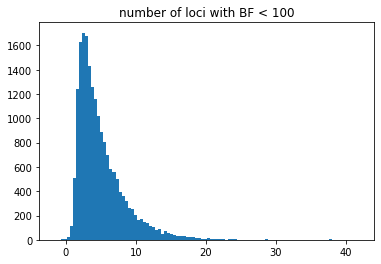



AHM 18750
	number of loci with meanBF >= 0 :  18741 (False)
	number of loci with meanBF >= 10 :  3883
	number of loci with meanBF >= 15 :  2241
	number of loci with meanBF >= 20 :  1793
	fraction of BF >= 15 :  0.12
	fraction of BF >= 10 :  0.21


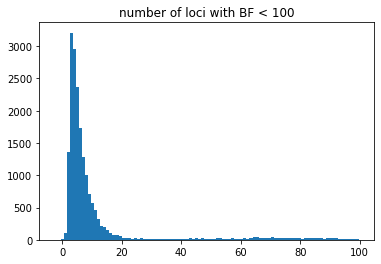



FFP 18749
	number of loci with meanBF >= 0 :  18727 (False)
	number of loci with meanBF >= 10 :  1423
	number of loci with meanBF >= 15 :  318
	number of loci with meanBF >= 20 :  102
	fraction of BF >= 15 :  0.02
	fraction of BF >= 10 :  0.08


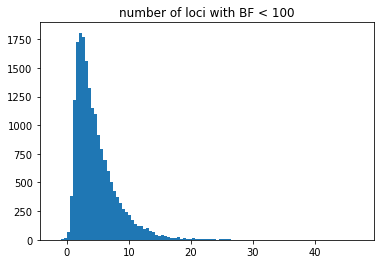



MWMT 20028
	number of loci with meanBF >= 0 :  20028 (True)
	number of loci with meanBF >= 10 :  3342
	number of loci with meanBF >= 15 :  843
	number of loci with meanBF >= 20 :  237
	fraction of BF >= 15 :  0.04
	fraction of BF >= 10 :  0.17


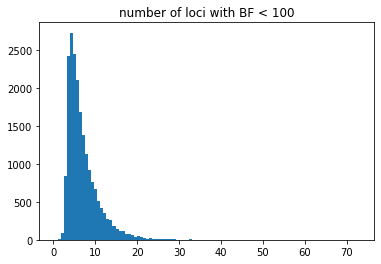



Eref 20778
	number of loci with meanBF >= 0 :  20778 (True)
	number of loci with meanBF >= 10 :  4840
	number of loci with meanBF >= 15 :  1299
	number of loci with meanBF >= 20 :  387
	fraction of BF >= 15 :  0.06
	fraction of BF >= 10 :  0.23


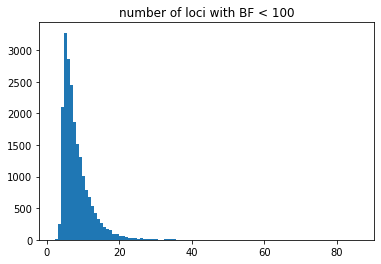



EMT 21217
	number of loci with meanBF >= 0 :  21217 (True)
	number of loci with meanBF >= 10 :  8097
	number of loci with meanBF >= 15 :  2379
	number of loci with meanBF >= 20 :  686
	fraction of BF >= 15 :  0.11
	fraction of BF >= 10 :  0.38


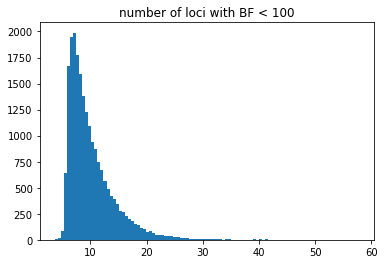



MAT 20655
	number of loci with meanBF >= 0 :  20655 (True)
	number of loci with meanBF >= 10 :  3850
	number of loci with meanBF >= 15 :  1026
	number of loci with meanBF >= 20 :  313
	fraction of BF >= 15 :  0.05
	fraction of BF >= 10 :  0.19


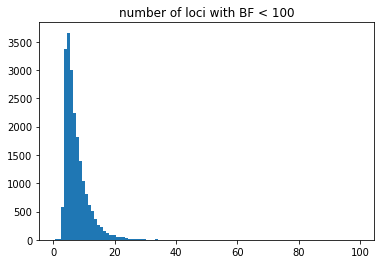



MSP 17594
	number of loci with meanBF >= 0 :  17511 (False)
	number of loci with meanBF >= 10 :  2793
	number of loci with meanBF >= 15 :  1605
	number of loci with meanBF >= 20 :  1107
	fraction of BF >= 15 :  0.09
	fraction of BF >= 10 :  0.16


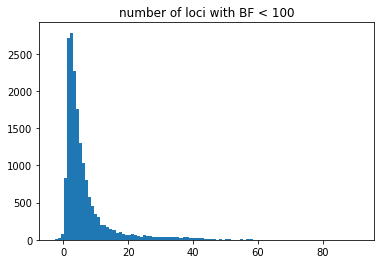



MAP 18601
	number of loci with meanBF >= 0 :  18600 (False)
	number of loci with meanBF >= 10 :  4345
	number of loci with meanBF >= 15 :  2353
	number of loci with meanBF >= 20 :  1709
	fraction of BF >= 15 :  0.13
	fraction of BF >= 10 :  0.23


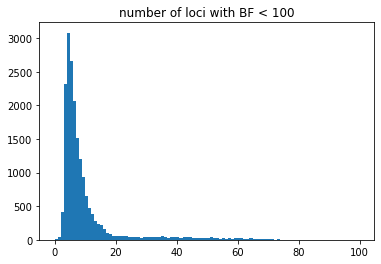



SHM 18814
	number of loci with meanBF >= 0 :  18769 (False)
	number of loci with meanBF >= 10 :  3040
	number of loci with meanBF >= 15 :  1814
	number of loci with meanBF >= 20 :  1431
	fraction of BF >= 15 :  0.1
	fraction of BF >= 10 :  0.16


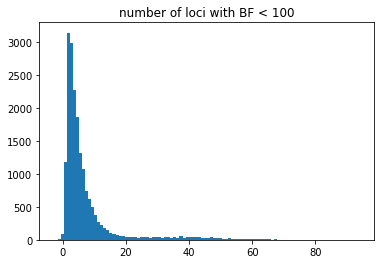



PAS 18367
	number of loci with meanBF >= 0 :  18350 (False)
	number of loci with meanBF >= 10 :  3154
	number of loci with meanBF >= 15 :  1822
	number of loci with meanBF >= 20 :  1377
	fraction of BF >= 15 :  0.1
	fraction of BF >= 10 :  0.17


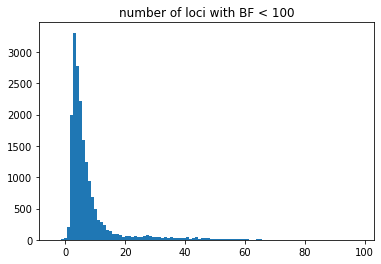



EXT 20415
	number of loci with meanBF >= 0 :  20415 (True)
	number of loci with meanBF >= 10 :  3998
	number of loci with meanBF >= 15 :  1033
	number of loci with meanBF >= 20 :  288
	fraction of BF >= 15 :  0.05
	fraction of BF >= 10 :  0.2


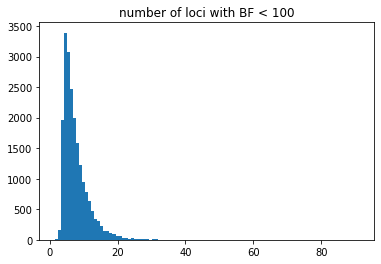



NFFD 19632
	number of loci with meanBF >= 0 :  19630 (False)
	number of loci with meanBF >= 10 :  2157
	number of loci with meanBF >= 15 :  529
	number of loci with meanBF >= 20 :  146
	fraction of BF >= 15 :  0.03
	fraction of BF >= 10 :  0.11


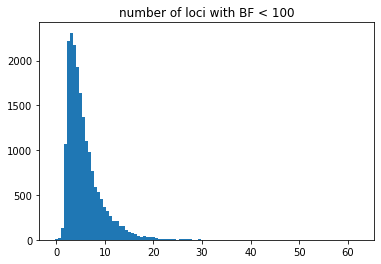



DD_0 21152
	number of loci with meanBF >= 0 :  21152 (True)
	number of loci with meanBF >= 10 :  5934
	number of loci with meanBF >= 15 :  1692
	number of loci with meanBF >= 20 :  530
	fraction of BF >= 15 :  0.08
	fraction of BF >= 10 :  0.28


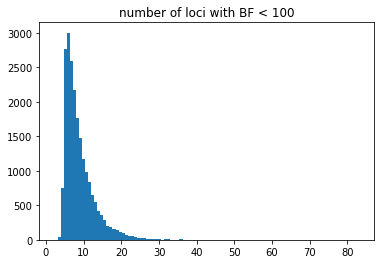



bFFP 18863
	number of loci with meanBF >= 0 :  18845 (False)
	number of loci with meanBF >= 10 :  1620
	number of loci with meanBF >= 15 :  389
	number of loci with meanBF >= 20 :  105
	fraction of BF >= 15 :  0.02
	fraction of BF >= 10 :  0.09


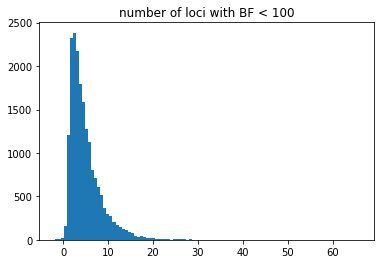



CMD 18426
	number of loci with meanBF >= 0 :  18343 (False)
	number of loci with meanBF >= 10 :  2595
	number of loci with meanBF >= 15 :  1615
	number of loci with meanBF >= 20 :  1234
	fraction of BF >= 15 :  0.09
	fraction of BF >= 10 :  0.14


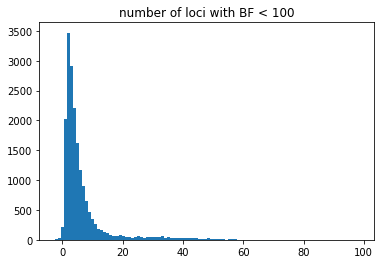



DD5 20043
	number of loci with meanBF >= 0 :  20042 (False)
	number of loci with meanBF >= 10 :  2625
	number of loci with meanBF >= 15 :  694
	number of loci with meanBF >= 20 :  185
	fraction of BF >= 15 :  0.03
	fraction of BF >= 10 :  0.13


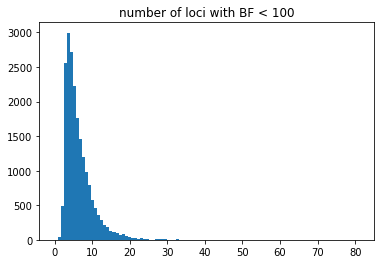



MCMT 21870
	number of loci with meanBF >= 0 :  21870 (True)
	number of loci with meanBF >= 10 :  11747
	number of loci with meanBF >= 15 :  3774
	number of loci with meanBF >= 20 :  1207
	fraction of BF >= 15 :  0.17
	fraction of BF >= 10 :  0.54


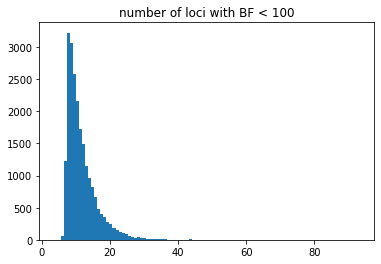



TD 20765
	number of loci with meanBF >= 0 :  20765 (True)
	number of loci with meanBF >= 10 :  13335
	number of loci with meanBF >= 15 :  4153
	number of loci with meanBF >= 20 :  1297
	fraction of BF >= 15 :  0.2
	fraction of BF >= 10 :  0.64


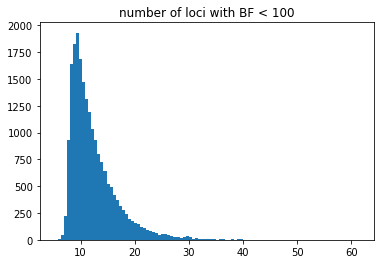




Fraction of meanBF >=15 across envs


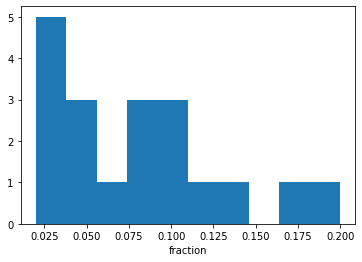

,eFFP,AHM,FFP,MWMT,Eref,EMT,MAT,MSP,MAP,SHM,PAS,EXT,NFFD,DD_0,bFFP,CMD,DD5,MCMT,TD
0,0.02,0.12,0.02,0.04,0.06,0.11,0.05,0.09,0.13,0.1,0.1,0.05,0.03,0.08,0.02,0.09,0.03,0.17,0.2


In [35]:
# for **ONLY** those loci that are consistently ranked in top 1%
# print histograms of bayes factor for each environment
# print fraction of top 1%BFs that have BF ≥ 15 or BF ≥ 20
# also look at histogram for BFs < 100

# also count number of loci across all SNPs that have BF ≥ 15 or BF ≥ 20, print if count doesn't match top 1%
fracs = defaultdict(dict)
for env,df in envdfs.items():
    df = df[df['rank_consistency_top1perc_for-gte3chains'] == True]
    BFs = df['mean_BF(dB)']
    small15 = sum(BFs >= 15)
    small20 = sum(BFs >= 20)
    print(ColorText(env).bold(), nrow(df))
    print('\tnumber of loci with meanBF >= 0 : ', sum(BFs >= 0), "(%s)" % str(sum(BFs >= 0) == nrow(df)))
    print('\tnumber of loci with meanBF >= 10 : ', sum(BFs >= 10))
    print('\tnumber of loci with meanBF >= 15 : ', small15)
    print('\tnumber of loci with meanBF >= 20 : ', small20)
    frac = round(sum(BFs >= 15)/nrow(df), 2)
    frac2 = round(sum(BFs >= 10)/nrow(df), 2)
    fracs[env][0] = frac
    print('\tfraction of BF >= 15 : ', frac)
    print('\tfraction of BF >= 10 : ', frac2)
    sum15 = sum(envdfs[env]['mean_BF(dB)'] >= 15)
    sum20 = sum(envdfs[env]['mean_BF(dB)'] >= 20)
    if small15 != sum15:
        text = '\tnot all SNPs with BF >= 15 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum15}) vs 1% ({small15}) (diff = {sum15 - small15})").warn().bold())
    if small20 != sum20:
        text = '\tnot all SNPs with BF >= 20 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum20}) vs 1% ({small20}) (diff = {sum20 - small20})").warn().bold())
    plt.hist(BFs[BFs<100], bins=100)
    plt.title('number of loci with BF < 100')
    plt.show()
    print('\n')

# create histogram for fraction of SNPs in consistent top 1% across environments
print(ColorText('\nFraction of meanBF >=15 across envs').bold())
fracdf = pd.DataFrame(fracs)
plt.hist(fracdf.loc[0,:])
plt.xlabel('fraction')
plt.show()
fracdf